In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Problem formulation

1. **Use case:** *Predict the final house sale price to support property valuation, pricing strategy, and investment analysis.*
2. **Unit of prediction:** *One property listing (house) represented by a single row of structured features describing its characteristics.*
3. **Metrics:** *RMSE*
4. **Target:** *SalePrice*

## 2. Data
**dataset** [https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview]

# 3. Explority Data Analisys

In [2]:
# loading of dataset
df = pd.read_csv("data/house_train.csv")

## - Dataset overview (dataset size, feature count, missings, types)

In [3]:
 df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [4]:
df.shape

(1460, 81)

**-- there are no many samples (1460) and so there is a risk of overfitting --**

In [5]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   str    
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   str    
 6   Alley          91 non-null     str    
 7   LotShape       1460 non-null   str    
 8   LandContour    1460 non-null   str    
 9   Utilities      1460 non-null   str    
 10  LotConfig      1460 non-null   str    
 11  LandSlope      1460 non-null   str    
 12  Neighborhood   1460 non-null   str    
 13  Condition1     1460 non-null   str    
 14  Condition2     1460 non-null   str    
 15  BldgType       1460 non-null   str    
 16  HouseStyle     1460 non-null   str    
 17  OverallQual    1460 non-null   int64  
 18  OverallCond    1460

In [6]:
numeric_features = df.select_dtypes(include='number').columns
categor_features = df.select_dtypes(exclude='number').columns
(numeric_features, categor_features)

(Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
        'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
        'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
        'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
        'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
        'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
        'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
        'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
       dtype='str'),
 Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       

**-- split features by nuneric and categorical --**

In [7]:
# dir(df.describe())

In [8]:
def dataset_overview_report(df):
    report = pd.DataFrame({
        "dtype": df.dtypes,
        "missing_count": df.isnull().sum(),
        "missing_percent": df.isnull().mean() * 100,
        "unique": df.nunique()
    }).sort_values("missing_percent", ascending=False)
    return report

In [9]:
report = dataset_overview_report(df)

In [10]:
print(report.to_string())

                 dtype  missing_count  missing_percent  unique
PoolQC             str           1453        99.520548       3
MiscFeature        str           1406        96.301370       4
Alley              str           1369        93.767123       2
Fence              str           1179        80.753425       4
MasVnrType         str            872        59.726027       3
FireplaceQu        str            690        47.260274       5
LotFrontage    float64            259        17.739726     110
GarageYrBlt    float64             81         5.547945      97
GarageCond         str             81         5.547945       5
GarageType         str             81         5.547945       6
GarageFinish       str             81         5.547945       3
GarageQual         str             81         5.547945       5
BsmtFinType2       str             38         2.602740       6
BsmtExposure       str             38         2.602740       4
BsmtQual           str             37         2.534247 

## Summary Dataset Overview Report
The dataset contains **1460** samples and **81** features. There is a **risk of overfitting**.

### Features – candidates to remove
Features with very high missing percentage (>80%) have low information value and can be removed:
- PoolQC (99.5%)
- MiscFeature (96.3%)
- Alley (93.8%)
- Fence (80.8%)

### Identifier
- `Id` contains fully unique values (1460 unique) and should be removed from the feature set since it does not have information.

### Features requiring imputation
- High missing:
  - MasVnrType (59.7%)
  - FireplaceQu (47.3%)
- Medium missing:
  - LotFrontage (17.7%)
  - Garage* features (~5.5%)
  - Bsmt* features (~2.5%)

### Dataset contains:
- **numeric feature:** 'Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
        'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
        'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
        'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
        'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
        'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
        'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
        'MiscVal', 'MoSold', 'YrSold', 'SalePrice'
- **categorical feature:** 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
        'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
        'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
        'SaleType', 'SaleCondition'

### Recommendation
1. Remove: PoolQC, MiscFeature, Alley, Fence (more then 80% of missings), (MasVnrType, FireplaceQu - ???)
2. Remove Id (no information)
3. Mean/Mode replacement: LotFrontage, Garage*, Bsmt*

## - Target Analysis (positive/negative, distribution, outliers)

In [11]:
y_name = 'SalePrice'
y = df[y_name]

In [12]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

**min = 34900, max = 755000, mean = ~181000**

<Axes: xlabel='SalePrice', ylabel='Count'>

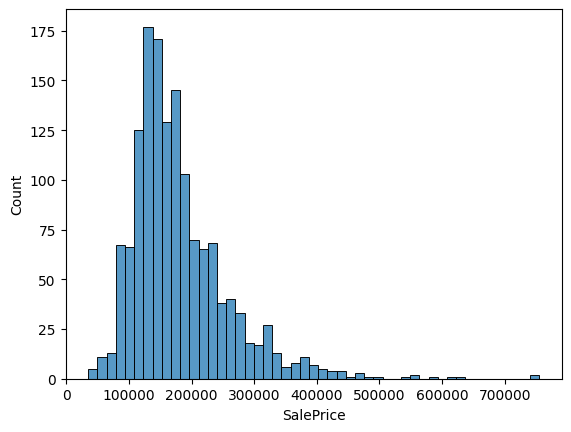

In [13]:
sns.histplot(y)

In [14]:
y.skew()

np.float64(1.8828757597682129)

**there is right skew distribution**

In [15]:
# apply log transformation for SalePrice to get info about outliers
y_log = np.log1p(y)

In [16]:
def check_iqr(s):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    IQR = q3 - q1
    top = q3 + 1.5 * IQR
    low = q1 - 1.5 * IQR
    return (low, top)

In [17]:
low, top = check_iqr(y_log)
target_outliers_low = y_log[(y_log < low)]
target_outliers_top = y_log[(y_log > top)]
outliers_percent_low = (len(target_outliers_low)*100)/ df.index.size
outliers_percent_top = (len(target_outliers_top)*100)/ df.index.size
(f'Low - {round(outliers_percent_low, 2)} %', f'Top - {round(outliers_percent_top, 2)} %')

('Low - 1.03 %', 'Top - 0.89 %')

<Axes: xlabel='SalePrice'>

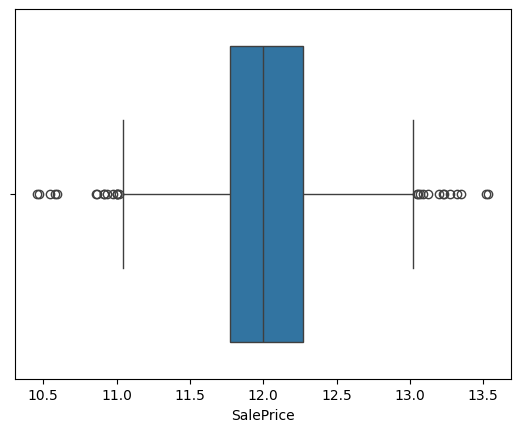

In [18]:
sns.boxplot(x=y_log)

## Summary Target Analysis Report

### Type: Continuous
Positive values only (no zero / negative observations)

### Distribution
Shape: Right-skewed, indicating a long upper tail.

### Outliers
- top (~1%)
- low (~1%)

### Recommendation
1. Log-transformation as the target has a right-skew distribution
2. Do not touch outliers, as the sales price has correct data without any issues

# - Feature Analysis

In [19]:
X = df.drop(columns=['SalePrice'])

In [20]:
def numeric_feature_report(df: DataFrame, skew_thrashold = 2, outlier_threshold = 0.02, missing_threshold = 0.3):
    columns = df.select_dtypes(include='number').columns

    rows = []
    
    for col in columns:
        s = df[col]
        skew = s.skew()
        low, top = check_iqr(s)
        outliers = ((s < low) | (s > top)).mean()
        missings = s.isnull().sum()/len(s)
        constant = s.nunique()

        flags = []
        recommendations = []
        if skew >= skew_thrashold:
            flags.append('right_skew')
            recommendations.append('log')

        if skew <= -skew_thrashold:
            flags.append('left_skew')

        if outliers > outlier_threshold:
            flags.append('many_outliers')

        if missings > missing_threshold:
            flags.append('many_missings')
            recommendations.append('drop')

        if missings <= 0.3 and missings > 0:
            recommendations.append('replace')

        if constant <= 1:
            flags.append('constant')
            recommendations.append('drop')

        if s.median() == 0 and s.quantile(0.01) == 0:
            flags.append('median_zero')
            recommendations.append('create_has_flag')

        rows.append({
            'feature_name': col,
            'min': s.min(),
            'p1': s.quantile(0.01),
            'mean': s.mean(),
            'median(p50)': s.median(),
            'p99': s.quantile(0.99),
            'max': s.max(),
            'distribution': skew,
            'outliers': outliers*100,
            'missings': missings*100,
            'flags': flags,
            'recommendations': recommendations,
        })

    return DataFrame(rows).sort_values('missings', ascending=False)

In [21]:
nf_report = numeric_feature_report(X)
nf_report

,feature_name,min,p1,mean,median(p50),p99,max,distribution,outliers,missings,flags,recommendations
2,LotFrontage,21.0,21.00,70.049958,69.0,141.00,313.0,2.163569,6.027397,17.739726,"[right_skew, many_outliers]","[log, replace]"
25,GarageYrBlt,1900.0,1916.00,1978.506164,1980.0,2009.00,2010.0,-0.649415,0.000000,5.547945,[],[replace]
8,MasVnrArea,0.0,0.00,103.685262,0.0,791.92,1600.0,2.669084,6.575342,0.547945,"[right_skew, many_outliers, median_zero]","[log, replace, create_has_flag]"
0,Id,1.0,15.59,730.500000,730.5,1445.41,1460.0,0.000000,0.000000,0.000000,[],[]
28,WoodDeckSF,0.0,0.00,94.244521,0.0,505.46,857.0,1.541376,2.191781,0.000000,"[many_outliers, median_zero]",[create_has_flag]
22,KitchenAbvGr,0.0,1.00,1.046575,1.0,2.00,3.0,4.488397,4.657534,0.000000,"[right_skew, many_outliers]",[log]
23,TotRmsAbvGrd,2.0,3.00,6.517808,6.0,11.00,14.0,0.676341,2.054795,0.000000,[many_outliers],[]
24,Fireplaces,0.0,0.00,0.613014,1.0,2.00,3.0,0.649565,0.342466,0.000000,[],[]
26,GarageCars,0.0,0.00,1.767123,2.0,3.00,4.0,-0.342549,0.342466,0.000000,[],[]
27,GarageArea,0.0,0.00,472.980137,480.0,1002.79,1418.0,0.179981,1.438356,0.000000,[],[]


In [22]:
def categorical_feature_report(df:DataFrame, rare_threshold = 0.01, domenant_threshold = 0.9, missing_threshold = 0.3):
    columns = df.select_dtypes(exclude='number').columns

    rows = []
    for col in columns:
        flags = []
        recommendations = []
        
        s:Series = df[col]
        
        missing = s.isnull().sum()/len(s)
        nunique = s.nunique(dropna=True)

        vc = s.value_counts(normalize=True, dropna=True)
        top_cat = vc.index[0] if len(vc) else None
        top_cat_prop = vc.iloc[0] if len(vc) else 0
        rare_cats = vc[vc <= rare_threshold].sum() if len(vc) else 0

        if missing > missing_threshold:
            flags.append('many_missings')
            recommendations.append('drop_candidate')

        if missing < missing_threshold and missing > 0:
            recommendations.append('replace')

        if nunique <= 1:
            flags.append('constant')
            recommendations.append('drop')

        if top_cat_prop >= domenant_threshold:
            flags.append('domenant')
            if top_cat_prop >= 0.95:
                recommendations.append('drop_candidate')
            else:
                recommendations.append('create_rare_flag')

        if rare_cats > 0.3:
            flags.append('many_rare')
            recommendations.append('collapse')

        rows.append({
            'feature_name': col,
            'missings': missing*100,
            'unique': nunique,
            'dominate': top_cat,
            'dominate_prop': top_cat_prop*100,
            'flags': flags,
            'recommendations': recommendations
        })

    return DataFrame(rows).sort_values(by='missings', ascending=False)

In [23]:
cf_report = categorical_feature_report(X)
cf_report

,feature_name,missings,unique,dominate,dominate_prop,flags,recommendations
38,PoolQC,99.520548,3,Gd,42.857143,[many_missings],[drop_candidate]
40,MiscFeature,96.301370,4,Shed,90.740741,"[many_missings, domenant]","[drop_candidate, create_rare_flag]"
2,Alley,93.767123,2,Grvl,54.945055,[many_missings],[drop_candidate]
39,Fence,80.753425,4,MnPrv,55.871886,[many_missings],[drop_candidate]
17,MasVnrType,59.726027,3,BrkFace,75.680272,[many_missings],[drop_candidate]
32,FireplaceQu,47.260274,5,Gd,49.350649,[many_missings],[drop_candidate]
33,GarageType,5.547945,6,Attchd,63.089195,[],[replace]
36,GarageCond,5.547945,5,TA,96.156635,[domenant],"[replace, drop_candidate]"
35,GarageQual,5.547945,5,TA,95.068891,[domenant],"[replace, drop_candidate]"
34,GarageFinish,5.547945,3,Unf,43.872371,[],[replace]


## Summary Feature Analysis Report

### 1. Log transformation recommended
Features with strong right skew / heavy tails where logarithmic scaling is recommended:

- LotFrontage  
- MasVnrArea  
- OpenPorchSF  
- KitchenAbvGr  
- EnclosedPorch  
- 3SsnPorch  
- ScreenPorch  
- PoolArea  
- MiscVal  
- BsmtFinSF2  
- LotArea  
- BsmtHalfBath  
- LowQualFinSF  

---

### 2. Missing value replacement recommended
Features where imputation is recommended:

#### Numerical
- LotFrontage  
- GarageYrBlt  
- MasVnrArea  

#### Categorical
- GarageType  
- GarageCond  
- GarageQual  
- GarageFinish  
- BsmtFinType2  
- BsmtExposure  
- BsmtFinType1  
- BsmtQual  
- BsmtCond  
- Electrical  

---

### 3. Create "has_feature" flag recommended
Binary indicator (feature > 0 or not) should be created:

- MasVnrArea  
- WoodDeckSF  
- EnclosedPorch  
- HalfBath  
- 3SsnPorch  
- ScreenPorch  
- PoolArea  
- MiscVal  
- BsmtFinSF2  
- BsmtHalfBath  
- 2ndFlrSF  
- LowQualFinSF  
- BsmtFullBath  

---

### 4. Create a rare-category flag recommended
Categorical features where rare values should be grouped:

- MiscFeature  
- BsmtCond  
- Electrical  
- CentralAir  
- Functional  
- LandSlope  
- PavedDrive  

---

### 5. Drop candidate features
High missing rate or near-constant distribution:

- PoolQC  
- MiscFeature  
- Alley  
- Fence  
- MasVnrType  
- FireplaceQu  
- Heating  
- Street  
- Condition2  
- Utilities  
- RoofMatl  

---

### 6. Optional drop (dominant category after imputation)
- GarageCond  
- GarageQual   


---

## Feature - Target interaction (correlation)

In [24]:
# temporary preprocessing

X_tmp = X.copy()

# group by 
feature_replace, feature_log, feature_flag, feature_drop = [], [], [], []

for _, r in pd.concat([nf_report, cf_report]).iterrows():
    rec = r['recommendations']
    fn = r['feature_name']
    if 'drop_candidate' in rec:
        feature_drop.append(fn)
        continue
    if 'replace' in rec:
        feature_replace.append(fn)
    if 'log' in rec:
        feature_log.append(fn)
    if 'create_has_flag' in rec:
        feature_flag.append(fn)

# drop features
for col in feature_drop:
    X_tmp = X_tmp.drop([col], axis=1)
    
# median replacement
for col in feature_replace:
    if X_tmp[col].dtype in [int, float]:
        X_tmp[col] = X_tmp[col].fillna(X_tmp[col].median())
    else:
        vc = X_tmp[col].value_counts()
        X_tmp[col] = X_tmp[col].fillna(vc.index[0])

# log transformation
for col in feature_log:
    X_tmp[col] = np.log1p(X_tmp[col])

# create - has_<feature>
for col in feature_flag:
    X_tmp['Has_' + col] = np.where(X_tmp[col] != 0, 1, 0)

In [25]:
numeric_feature_report(df)

,feature_name,min,p1,mean,median(p50),p99,max,distribution,outliers,missings,flags,recommendations
2,LotFrontage,21.0,21.00,70.049958,69.0,141.00,313.0,2.163569,6.027397,17.739726,"[right_skew, many_outliers]","[log, replace]"
25,GarageYrBlt,1900.0,1916.00,1978.506164,1980.0,2009.00,2010.0,-0.649415,0.000000,5.547945,[],[replace]
8,MasVnrArea,0.0,0.00,103.685262,0.0,791.92,1600.0,2.669084,6.575342,0.547945,"[right_skew, many_outliers, median_zero]","[log, replace, create_has_flag]"
0,Id,1.0,15.59,730.500000,730.5,1445.41,1460.0,0.000000,0.000000,0.000000,[],[]
29,OpenPorchSF,0.0,0.00,46.660274,25.0,285.82,547.0,2.364342,5.273973,0.000000,"[right_skew, many_outliers]",[log]
22,KitchenAbvGr,0.0,1.00,1.046575,1.0,2.00,3.0,4.488397,4.657534,0.000000,"[right_skew, many_outliers]",[log]
23,TotRmsAbvGrd,2.0,3.00,6.517808,6.0,11.00,14.0,0.676341,2.054795,0.000000,[many_outliers],[]
24,Fireplaces,0.0,0.00,0.613014,1.0,2.00,3.0,0.649565,0.342466,0.000000,[],[]
26,GarageCars,0.0,0.00,1.767123,2.0,3.00,4.0,-0.342549,0.342466,0.000000,[],[]
27,GarageArea,0.0,0.00,472.980137,480.0,1002.79,1418.0,0.179981,1.438356,0.000000,[],[]


<Axes: xlabel='LotFrontage', ylabel='Count'>

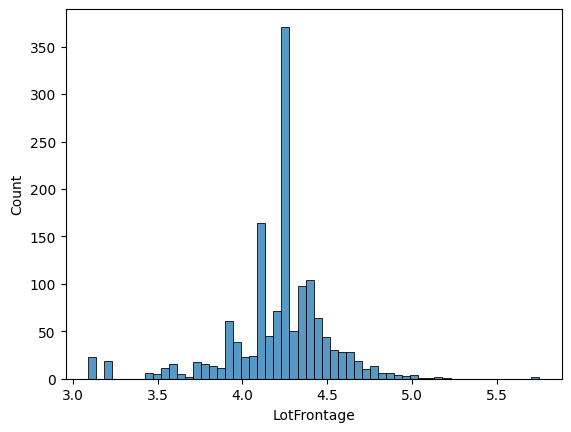

In [26]:
sns.histplot(X_tmp['LotFrontage'])

In [27]:
# report for origin dataset
numeric_feature_report(X[feature_log])[['feature_name','distribution', 'missings']]

,feature_name,distribution,missings
0,LotFrontage,2.163569,17.739726
1,MasVnrArea,2.669084,0.547945
2,KitchenAbvGr,4.488397,0.000000
3,EnclosedPorch,3.089872,0.000000
4,OpenPorchSF,2.364342,0.000000
5,3SsnPorch,10.304342,0.000000
6,ScreenPorch,4.122214,0.000000
7,PoolArea,14.828374,0.000000
8,MiscVal,24.476794,0.000000
9,BsmtHalfBath,4.103403,0.000000


In [28]:
# report for temp dataset after preprocessing
numeric_feature_report(X_tmp[feature_log])[['feature_name','distribution', 'missings']]

,feature_name,distribution,missings
0,LotFrontage,-0.870006,0.0
1,MasVnrArea,0.503532,0.0
2,KitchenAbvGr,3.869414,0.0
3,EnclosedPorch,2.112275,0.0
4,OpenPorchSF,-0.023397,0.0
5,3SsnPorch,7.734975,0.0
6,ScreenPorch,3.150409,0.0
7,PoolArea,14.363102,0.0
8,MiscVal,5.170704,0.0
9,BsmtHalfBath,3.933064,0.0


In [29]:
# report for origin dataset
categorical_feature_report(X[feature_replace])[['feature_name','missings']]

,feature_name,missings
0,GarageType,5.547945
1,GarageFinish,5.547945
2,BsmtFinType2,2.602740
3,BsmtExposure,2.602740
4,BsmtFinType1,2.534247
5,BsmtQual,2.534247
6,BsmtCond,2.534247
7,Electrical,0.068493


In [30]:
# report for temp dataset after preprocessing
categorical_feature_report(X_tmp[feature_replace])[['feature_name','missings']]

,feature_name,missings
0,GarageType,0.0
1,GarageFinish,0.0
2,BsmtFinType2,0.0
3,BsmtExposure,0.0
4,BsmtFinType1,0.0
5,BsmtQual,0.0
6,BsmtCond,0.0
7,Electrical,0.0


In [31]:
def numeric_feature_target_report(df: DataFrame, y: Series, corr_threshold = 0.05, mi_threshold = 0.01) -> DataFrame:
    columns = df.select_dtypes(include='number').columns

    rows = []
    for col in columns:
        flags = []
        recommendations = []
        corr_pearson = df[col].corr(y, method='pearson')
        corr_spearman = df[col].corr(y, method='spearman')
        mi = mutual_info_regression(df[[col]], y, random_state=42)

        if abs(corr_pearson) < corr_threshold:
            flags.append('corr_pearson_low')

        if abs(corr_pearson) < corr_threshold:
            flags.append('corr_spearman_low')

        if mi < mi_threshold:
            flags.append('mi_low')

        if set(['corr_pearson_low', 'corr_spearman_low', 'mi_low']).issubset(flags) or 'mi_low' in flags:
            recommendations.append('drop_candidate')
        
        rows.append({
            'feature_name': col,
            'corr_pearson': corr_pearson,
            'corr_spearman': corr_spearman,
            'mi': mi[0],
            'flags': flags,
            'recommendations': recommendations,
        })

    return DataFrame(rows)
    

In [32]:
nft_report = numeric_feature_target_report(X_tmp, y_log)
nft_report

,feature_name,corr_pearson,corr_spearman,mi,flags,recommendations
0,Id,-0.017942,-0.018546,0.000000,"[corr_pearson_low, corr_spearman_low, mi_low]",[drop_candidate]
1,MSSubClass,-0.073959,0.007192,0.281840,[],[]
2,LotFrontage,0.346237,0.375590,0.218353,[],[]
3,LotArea,0.399923,0.456461,0.199180,[],[]
4,OverallQual,0.817185,0.809829,0.564260,[],[]
5,OverallCond,-0.036868,-0.129325,0.113152,"[corr_pearson_low, corr_spearman_low]",[]
6,YearBuilt,0.586570,0.652682,0.365712,[],[]
7,YearRemodAdd,0.565608,0.571159,0.240690,[],[]
8,MasVnrArea,0.413318,0.415906,0.115724,[],[]
9,BsmtFinSF1,0.372023,0.301871,0.147257,[],[]


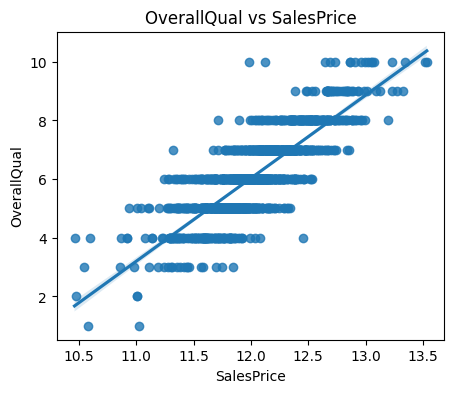

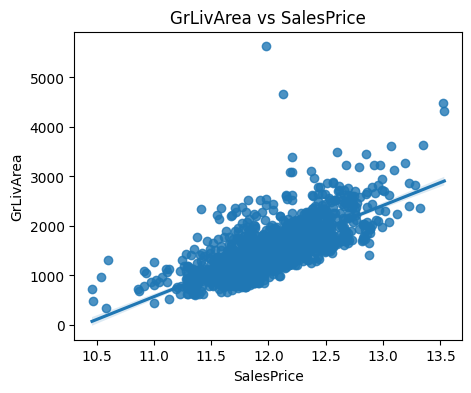

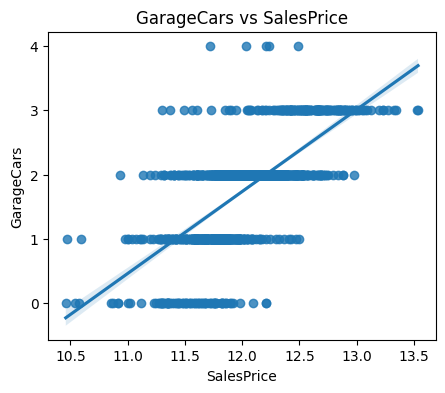

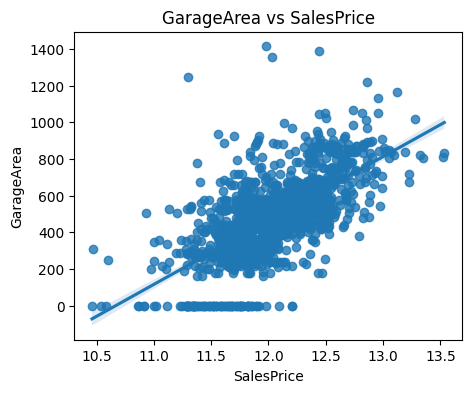

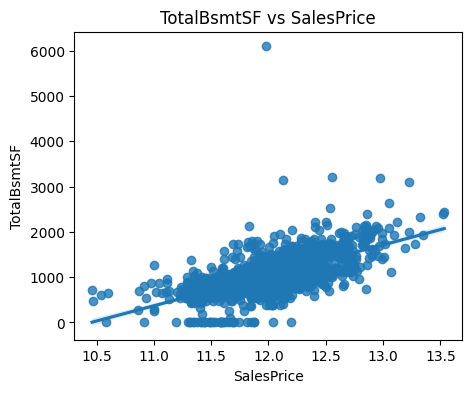

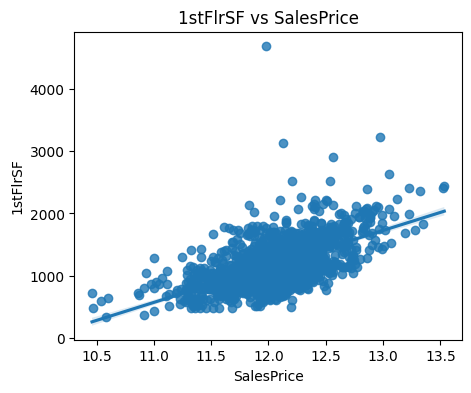

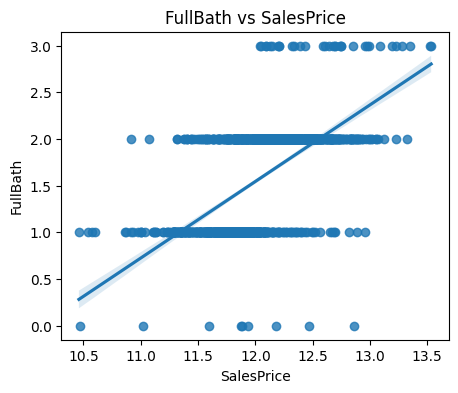

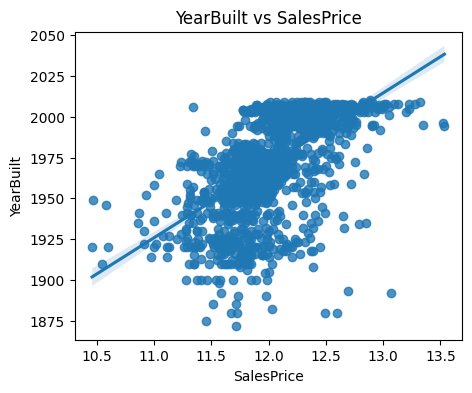

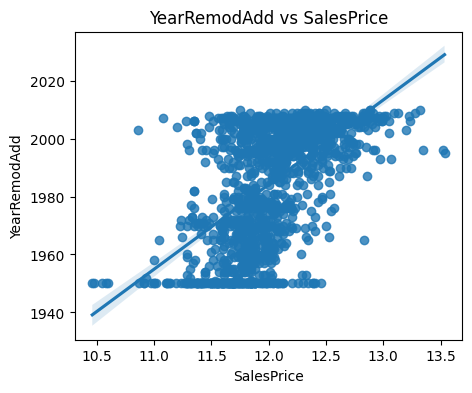

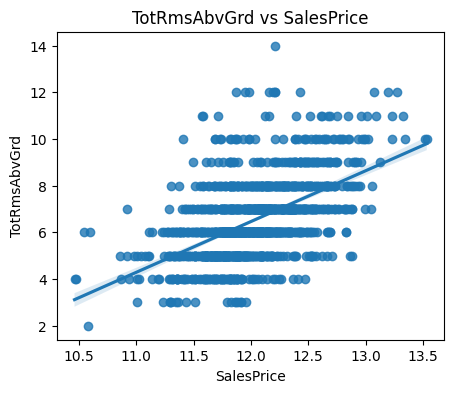

In [33]:
# numeric features <-> target
tmp_report = nft_report.copy()
d = X_tmp.copy()
tmp_report['corr_pearson'] = tmp_report['corr_pearson'].abs()
columns = tmp_report.nlargest(10, ['corr_pearson'])['feature_name']
d['SalesPrice'] = y_log
for col in columns:
    fig, ax = plt.subplots(figsize=(5,4))
    sns.regplot(data=d, x='SalesPrice', y=col, ax=ax)
    ax.set_title(f'{col} vs SalesPrice')
plt.show()

In [34]:
def cat_feature_target_report(df:DataFrame, y:Series, mi_threshold = 0.01) -> DataFrame:
    df_tmp = df.copy()
    columns = df_tmp.select_dtypes(exclude='number').columns
    
    rows = []
    for col in columns:
        flags = []
        recommendations = []

        df_tmp[col], _ = pd.factorize(df_tmp[col])
        mi = mutual_info_regression(df_tmp[[col]], y, random_state=42)

        if mi < mi_threshold:
            flags.append('mi_low')
            recommendations.append('drop_candidate')

        rows.append({
            'feature_name': col,
            'mi':mi[0],
            'flags': flags,
            'recommendations': recommendations,
        })
    return DataFrame(rows).sort_values(by='mi', ascending=False)
        

In [35]:
cft_report = cat_feature_target_report(X_tmp, y_log)
cft_report

,feature_name,mi,flags,recommendations
5,Neighborhood,0.502819,[],[]
12,ExterQual,0.333843,[],[]
23,KitchenQual,0.327476,[],[]
15,BsmtQual,0.316660,[],[]
26,GarageFinish,0.242252,[],[]
14,Foundation,0.197390,[],[]
20,HeatingQC,0.166816,[],[]
11,Exterior2nd,0.159748,[],[]
18,BsmtFinType1,0.141646,[],[]
10,Exterior1st,0.128119,[],[]


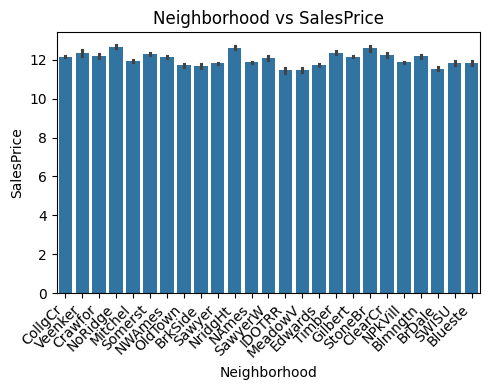

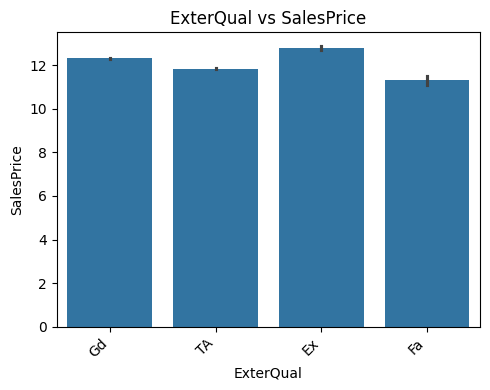

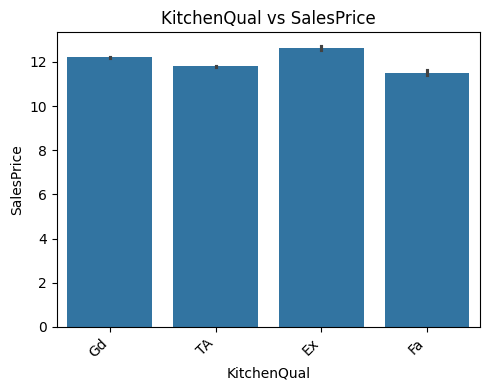

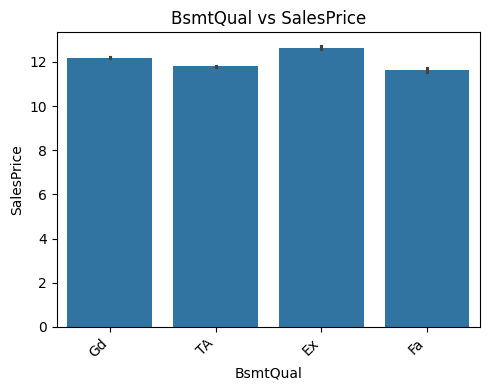

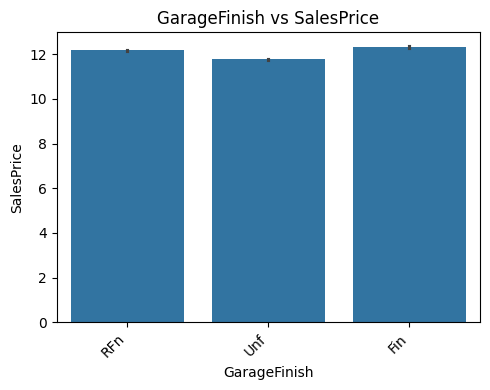

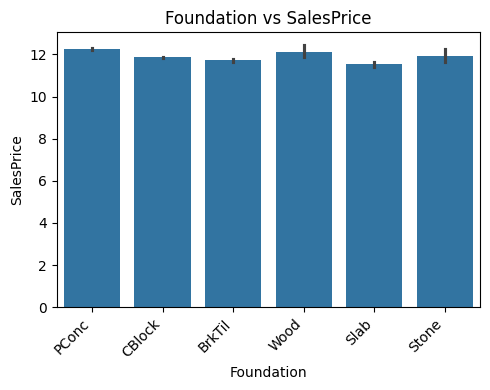

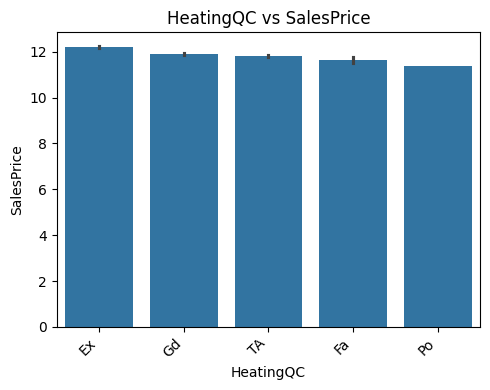

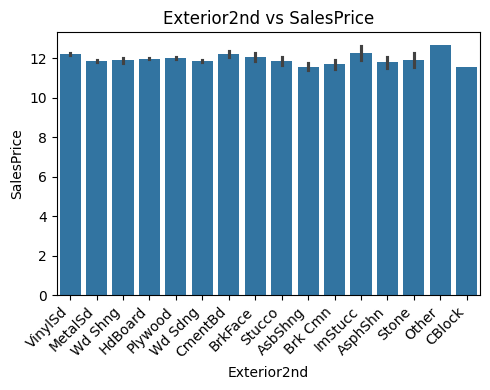

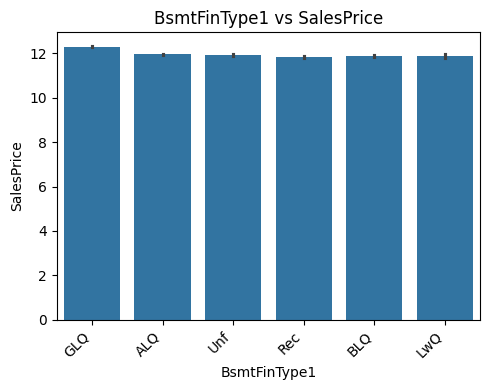

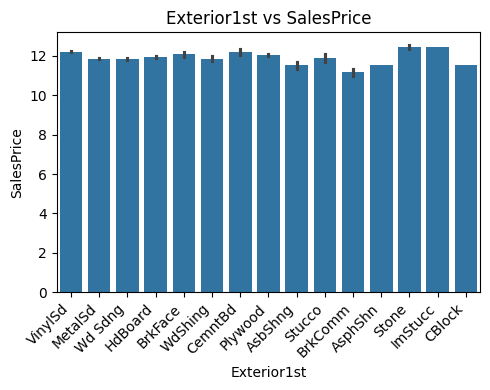

In [36]:
# categorical features <-> target
tmp_report = cft_report.copy()
d = X_tmp.copy()
d['SalesPrice'] = y_log
columns = tmp_report.nlargest(10, 'mi')['feature_name']
for col in columns:
    plt.figure(figsize=(5, 4))
    sns.barplot(data=d, x=col, y='SalesPrice')  # errorbar=None чтобы не шумело
    plt.title(f'{col} vs SalesPrice')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
plt.show()

## Summary Feature Analysis Report

### Drop candidates — Numerical
**Reason:** very low linear correlation (Pearson/Spearman) and/or near-zero mutual information, indicating minimal predictive signal.

- Id 
- BsmtFinSF2  
- LowQualFinSF  
- BsmtHalfBath  
- 3SsnPorch  
- PoolArea  
- MiscVal  
- MoSold  
- YrSold  
- Has_3SsnPorch  
- Has_PoolArea  
- Has_MiscVal  
- Has_BsmtHalfBath  
- Has_BsmtFinSF2  
- Has_LowQualFinSF 

---

### Drop candidates — Categorical
**Reason:** very low mutual information (weak dependency with target).

- BsmtFinType2  
- Functional  
- LandSlope  

---

### Low correlation (review later)
**Reason:** weak linear relationship but may still contribute via nonlinear effects or interactions.

- OverallCond  
- KitchenAbvGr  
- EnclosedPorch  
- Has_EnclosedPorch  

Recommended: keep temporarily and validate via model-based importance.

---

## Strong categorical predictors (keep)
**Reason:** high mutual information — strong dependency with target.

- Neighborhood  
- ExterQual  
- KitchenQual  
- BsmtQual  
- GarageFinish  
- Foundation  
- HeatingQC  
- Exterior2nd  
- BsmtFinType1  
- Exterior1st  
- GarageType  
- MSZoning  


## Feature - Feature interaction (correlation, VIF)

In [59]:
# correlation between features
num_columns = X_tmp.select_dtypes(include='number')
corr_pearson_matrix = num_columns.corr(method='pearson').abs()
up_val = corr_pearson_matrix.where(np.triu(m=np.ones(corr_pearson_matrix.shape), k=1).astype(bool))
highest_cols = [col for col in up_val.columns if any(up_val[col] > 0.5)]
highest_cols

['LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'TotRmsAbvGrd',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'Has_MasVnrArea',
 'Has_WoodDeckSF',
 'Has_EnclosedPorch',
 'Has_HalfBath',
 'Has_3SsnPorch',
 'Has_ScreenPorch',
 'Has_PoolArea',
 'Has_MiscVal',
 'Has_BsmtHalfBath',
 'Has_BsmtFinSF2',
 'Has_2ndFlrSF',
 'Has_LowQualFinSF',
 'Has_BsmtFullBath']

<Axes: >

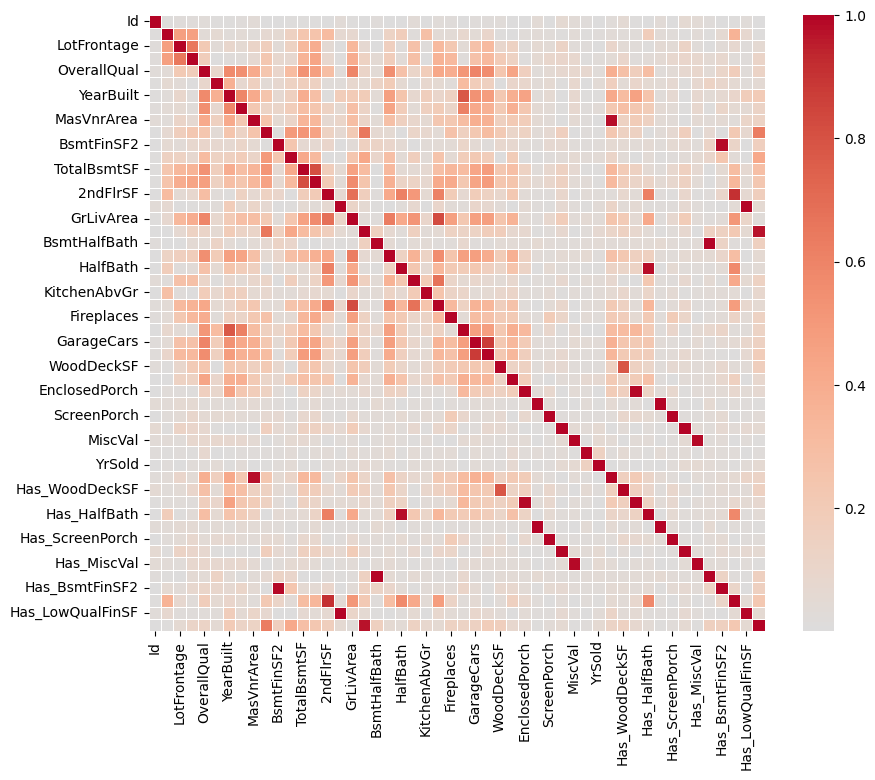

In [60]:
plt.figure(figsize=(10,8))
sns.heatmap(
    corr_pearson_matrix, 
    cmap="coolwarm",
    linewidths=0.5,         
    square=True,            
    center=0,
)

In [42]:
# Variance Inflation Factor (multicollinearity)
columns = X_tmp.select_dtypes(include='number').columns
print(columns)
vif_data = pd.DataFrame()
vif_data["feature"] = columns
vif_data["VIF"] = [
    variance_inflation_factor(X_tmp[columns].values, i)
    for i in range(X_tmp[columns].shape[1])
]

print(vif_data.sort_values("VIF", ascending=False))

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'Has_MasVnrArea', 'Has_WoodDeckSF',
       'Has_EnclosedPorch', 'Has_HalfBath', 'Has_3SsnPorch', 'Has_ScreenPorch',
       'Has_PoolArea', 'Has_MiscVal', 'Has_BsmtHalfBath', 'Has_BsmtFinSF2',
       'Has_2ndFlrSF', 'Has_LowQualFinSF', 'Has_BsmtFullBath'],
      dtype='str')
              feature           VIF
16          GrLivArea  86493.100584
13           1stFlrSF  50750.432078
36             YrSold  27920.250973
6           YearBui